# Bayesian/Frequentist Tutorial

In [1]:
# Author: ejolly

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymer4.simulate import simulate_lm, simulate_lmm
import os
from glob import glob
import arviz as az

In [3]:
az.style.use('arviz-darkgrid')

In this notebook we demo how to perform the same set of analyses using a frequentist approach and a bayesian approach.  
We'll perform two sets of analyses:  
1) Simple between groups t-test (i.e. univariate regression with dummy-coding)   
2) Multi-level multivariate regression model (with two predictors)  
We'll estimate the frequentist statistics using [pymer4](http://eshinjolly.com/pymer4/).  

## Generate t-test data

In [4]:
a = np.random.normal(5,2,1000)
b = np.random.normal(8,2.5,1000)
df = pd.DataFrame({'Group':['a']*1000 + ['b']*1000,'Val':np.hstack([a,b])})

In [5]:
df.groupby('Group').describe()

Val                                                              \
        count      mean       std       min       25%       50%       75%   
Group                                                                       
a      1000.0  5.086596  2.028339 -1.379767  3.661714  5.068746  6.461149   
b      1000.0  7.948346  2.501498  0.359414  6.216262  7.924408  9.568836   

                  
             max  
Group             
a      11.410939  
b      16.131266

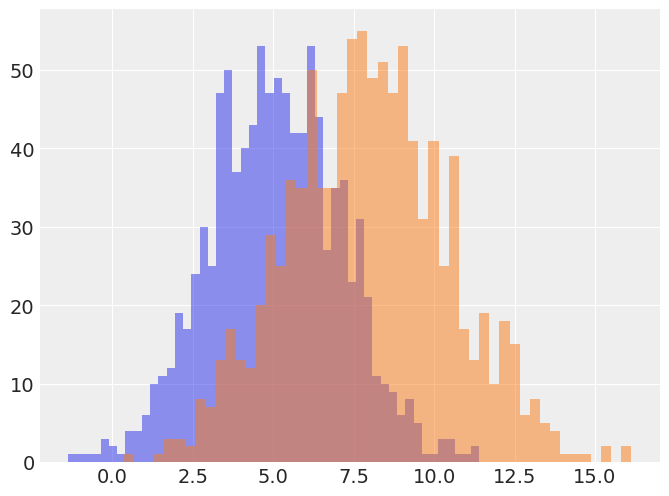

In [6]:
f,ax = plt.subplots(1,1,figsize=(8,6))
ax.hist(a,alpha=.5,bins=50);
ax.hist(b,alpha=.5,bins=50);

### Frequentist  
Since this analysis is relateively straightforward we can perform a between groups t-test using scipy

In [7]:
from scipy.stats import ttest_ind
ttest_ind(b,a)

Ttest_indResult(statistic=28.100091558988215, pvalue=1.0770966726487567e-146)

We can also set this up as a dummy-coded univariate regression model which is identical

In [8]:
# Using the pymer4 package, but we could have used statsmodels instead
from pymer4.models import Lm
model = Lm('Val ~ Group',data=df)
model.fit()

Formula: Val~Group

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2000	 R^2: 0.283	 R^2_adj: 0.283

Log-likelihood: -4482.806 	 AIC: 8969.611	 BIC: 8980.813

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,5.087,4.945,5.228,0.072,1998,70.635,0.0,***
Group[T.b],2.862,2.662,3.061,0.102,1998,28.100,0.0,***


### Bayesian
We can compute the equivalent dummy-coded regression model to estimate with bambi and the pymc3 backend

In [9]:
from bambi import Model
import pymc3 as pm
import bambi

b_model = Model(df)
res_b = b_model.fit('Val ~ Group',samples=1000,chains=3)

/home/osvaldo/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Val_sd, Group, Intercept]
INFO:pymc3:NUTS: [Val_sd, Group, Intercept]
Sampling 3 chains, 0 divergences: 100%|██████████| 4500/4500 [00:03<00:00, 1349.70draws/s]
The acceptance probability does not match the target. It is 0.8804212890770033, but should be close to 0.8. Try to increase the number of tuning steps.


In [10]:
# Here's the setup for the model
b_model.backend.model

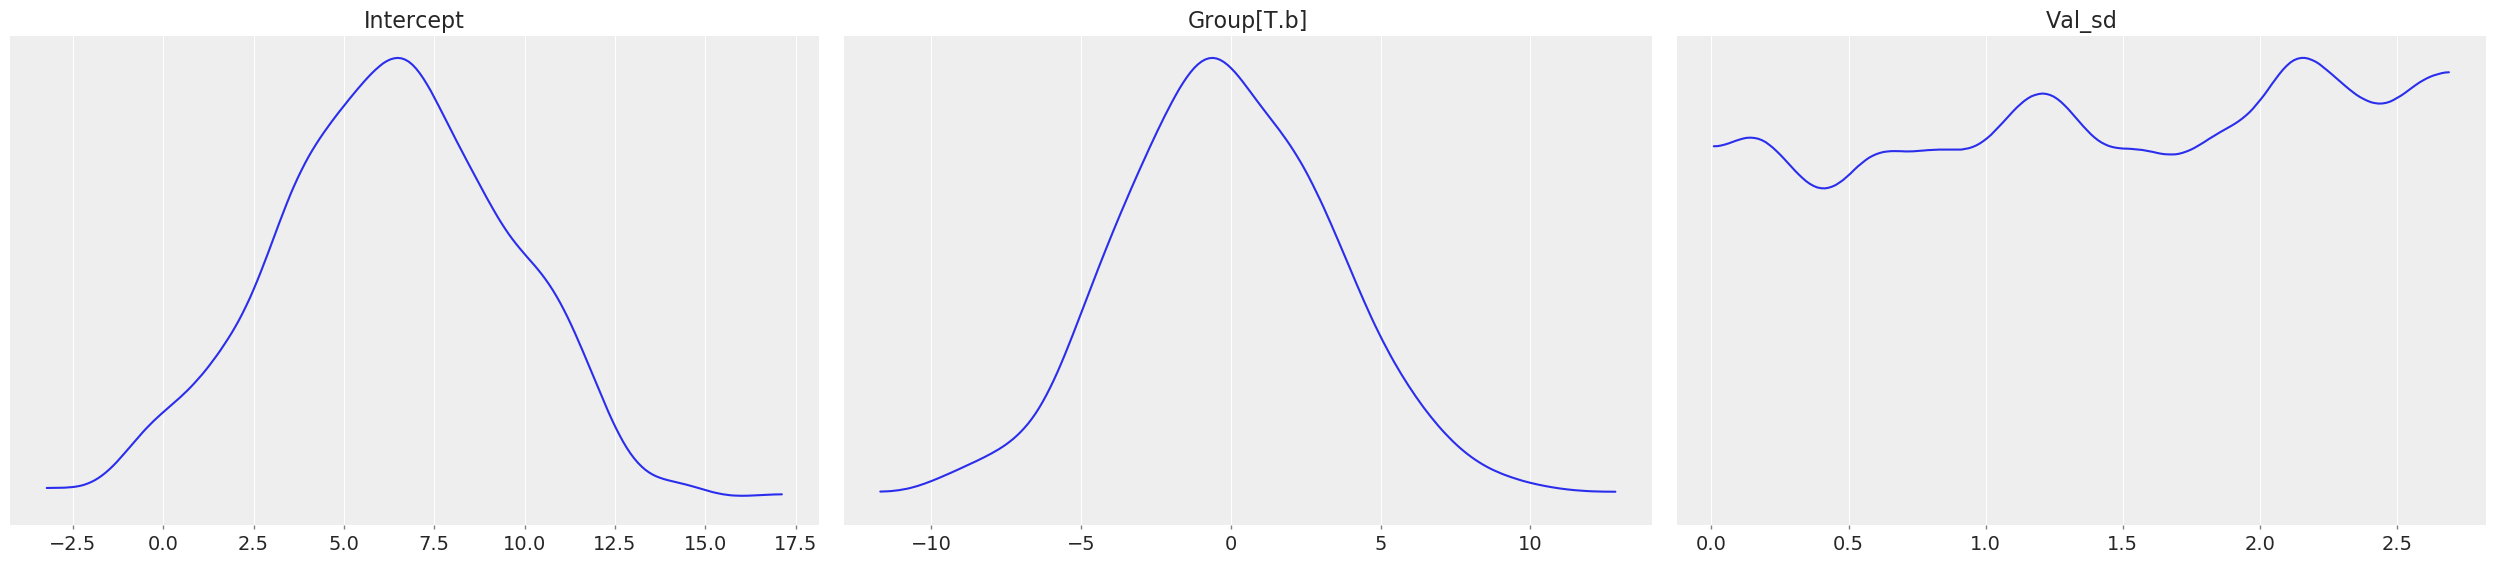

In [11]:
# Model priors
b_model.plot();

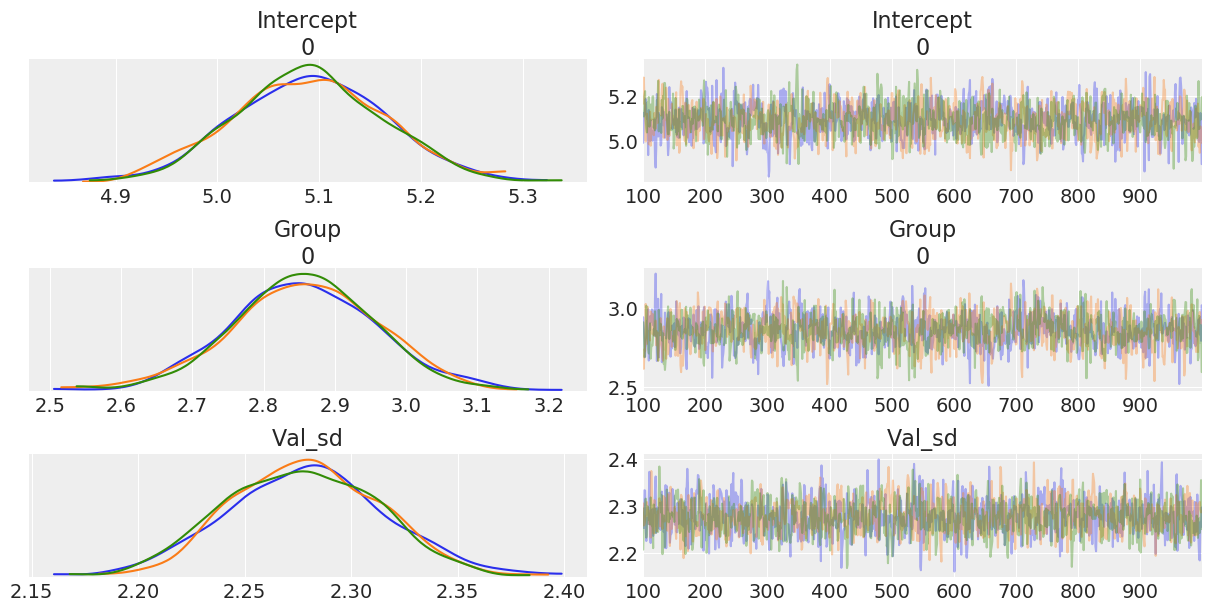

In [12]:
#Posterior plots removing first 100 samples for burn-in
res_b_sliced = res_b.posterior.sel(draw=slice(100, 1000))
az.plot_trace(res_b_sliced);

In [13]:
az.summary(res_b_sliced)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],5.090,0.073,4.953,5.226,0.002,0.001,1322.0,1321.0,1326.0,1509.0,1.0
Group[0],2.857,0.103,2.663,3.052,0.003,0.002,1339.0,1339.0,1340.0,1752.0,1.0
Val_sd,2.278,0.036,2.210,2.343,0.001,0.001,1855.0,1849.0,1867.0,1737.0,1.0


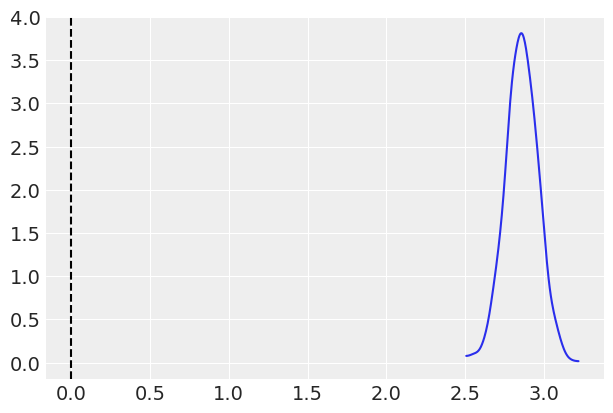

In [14]:
# Grab just the posterior of the term of interest (group)
group_posterior = res_b.posterior['Group'].values
ax = az.plot_kde(group_posterior)
ax.axvline(0, 0, 3, linestyle='--', color='k');

In [15]:
#Probabiliy that posterior is > 0
(group_posterior > 0).mean()

1.0

## Generate multi-level regression data

Generate data for a multivariate regression model with random intercepts and slope effect for each group

In [16]:
# Simulate some multi-level data with pymer4
from pymer4.simulate import simulate_lmm
df, blups, coefs = simulate_lmm(num_obs=500, num_coef=2, num_grps=25, coef_vals=[5,3,-1])
df.head()
blups.head()

,Intercept,IV1,IV2
Grp1,5.008387,3.133625,-0.695080
Grp2,5.114193,2.793351,-1.075684
Grp3,4.975569,2.994899,-1.348830
Grp4,5.247185,2.697167,-0.997635
Grp5,5.029060,3.941273,-0.888163


### Frequentist multi-level model

In [17]:
# Fit multi-level model using pymer4 (lmer in R)
from pymer4.models import Lmer
model = Lmer('DV ~ IV1 + IV2 + (IV1 + IV2|Group)',data=df)
model.fit()

Formula: DV~IV1+IV2+(IV1+IV2|Group)

Family: gaussian	 Inference: parametric

Number of observations: 12500	 Groups: {'Group': 25.0}

Log-likelihood: -17967.539 	 AIC: 35935.079

Random effects:

                 Name    Var    Std
Group     (Intercept)  0.038  0.196
Group             IV1  0.136  0.369
Group             IV2  0.050  0.224
Residual               1.016  1.008

               IV1  IV2   Corr
Group  (Intercept)  IV1  0.268
Group  (Intercept)  IV2  0.019
Group          IV1  IV2  0.266

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),5.058,4.979,5.137,0.040,23.993,125.957,0.0,***
IV1,3.038,2.892,3.184,0.074,24.012,40.835,0.0,***
IV2,-0.966,-1.055,-0.876,0.046,23.944,-21.107,0.0,***


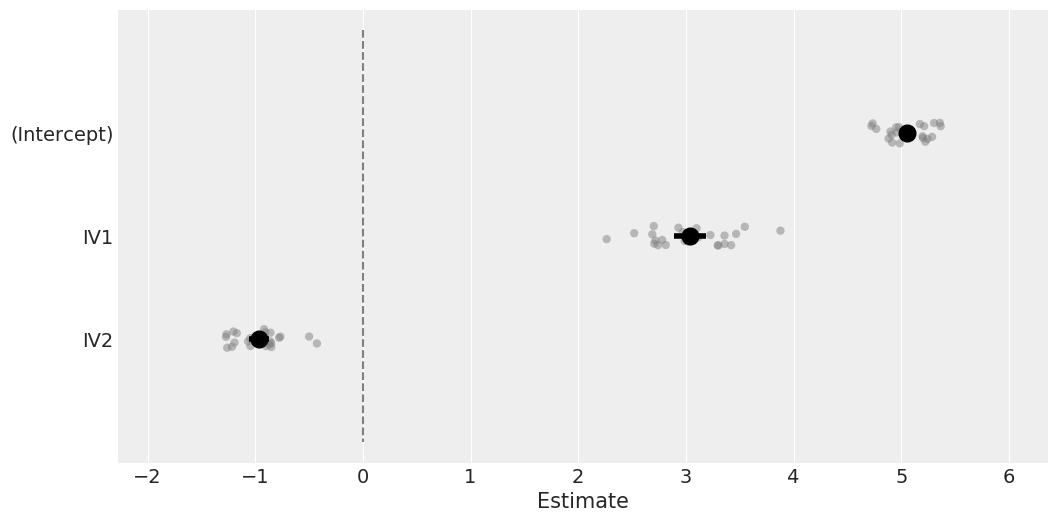

In [18]:
# Plot coefficients and the group BLUPs as well
model.plot_summary();

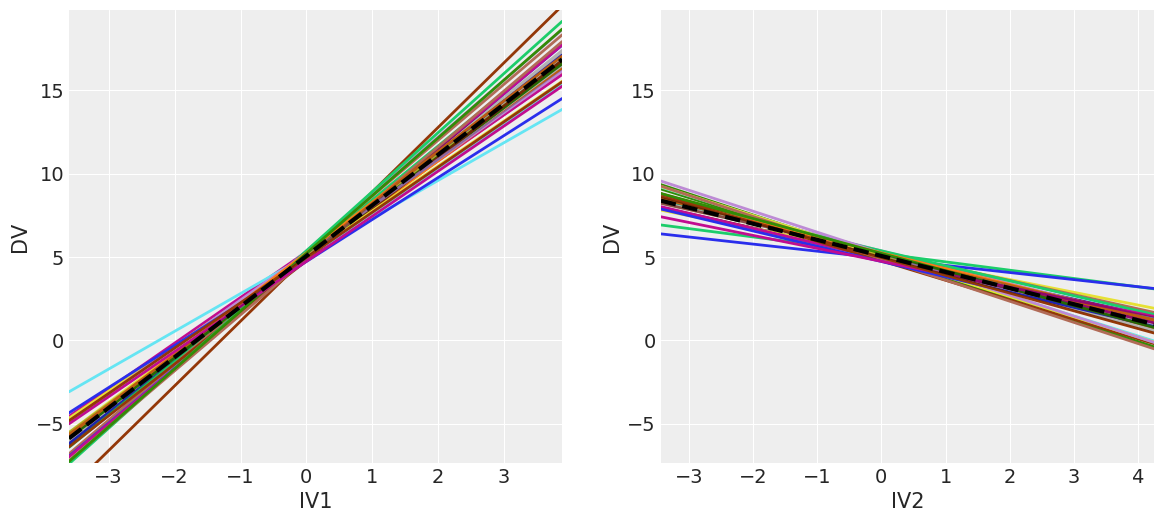

In [19]:
# Alternatively visualize coefficients as regression lines with BLUPs overlaid
_, axs = plt.subplots(1, 2, figsize=(14, 6))
model.plot('IV1', ax=axs[0],)
model.plot('IV2', ax=axs[1])

### Bayesian multi-level model

In [20]:
b_model = Model(df)
results = b_model.fit('DV ~ IV1 + IV2',random=['IV1+IV2|Group'],samples=1000,chains=3)

/home/osvaldo/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 3 jobs)
NUTS: [DV_sd, IV2|Group_offset, IV2|Group_sd, IV1|Group_offset, IV1|Group_sd, 1|Group_offset, 1|Group_sd, IV2, IV1, Intercept]
INFO:pymc3:NUTS: [DV_sd, IV2|Group_offset, IV2|Group_sd, IV1|Group_offset, IV1|Group_sd, 1|Group_offset, 1|Group_sd, IV2, IV1, Intercept]
Sampling 3 chains, 0 divergences: 100%|██████████| 4500/4500 [02:08<00:00, 35.02draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [21]:
b_model.backend.model

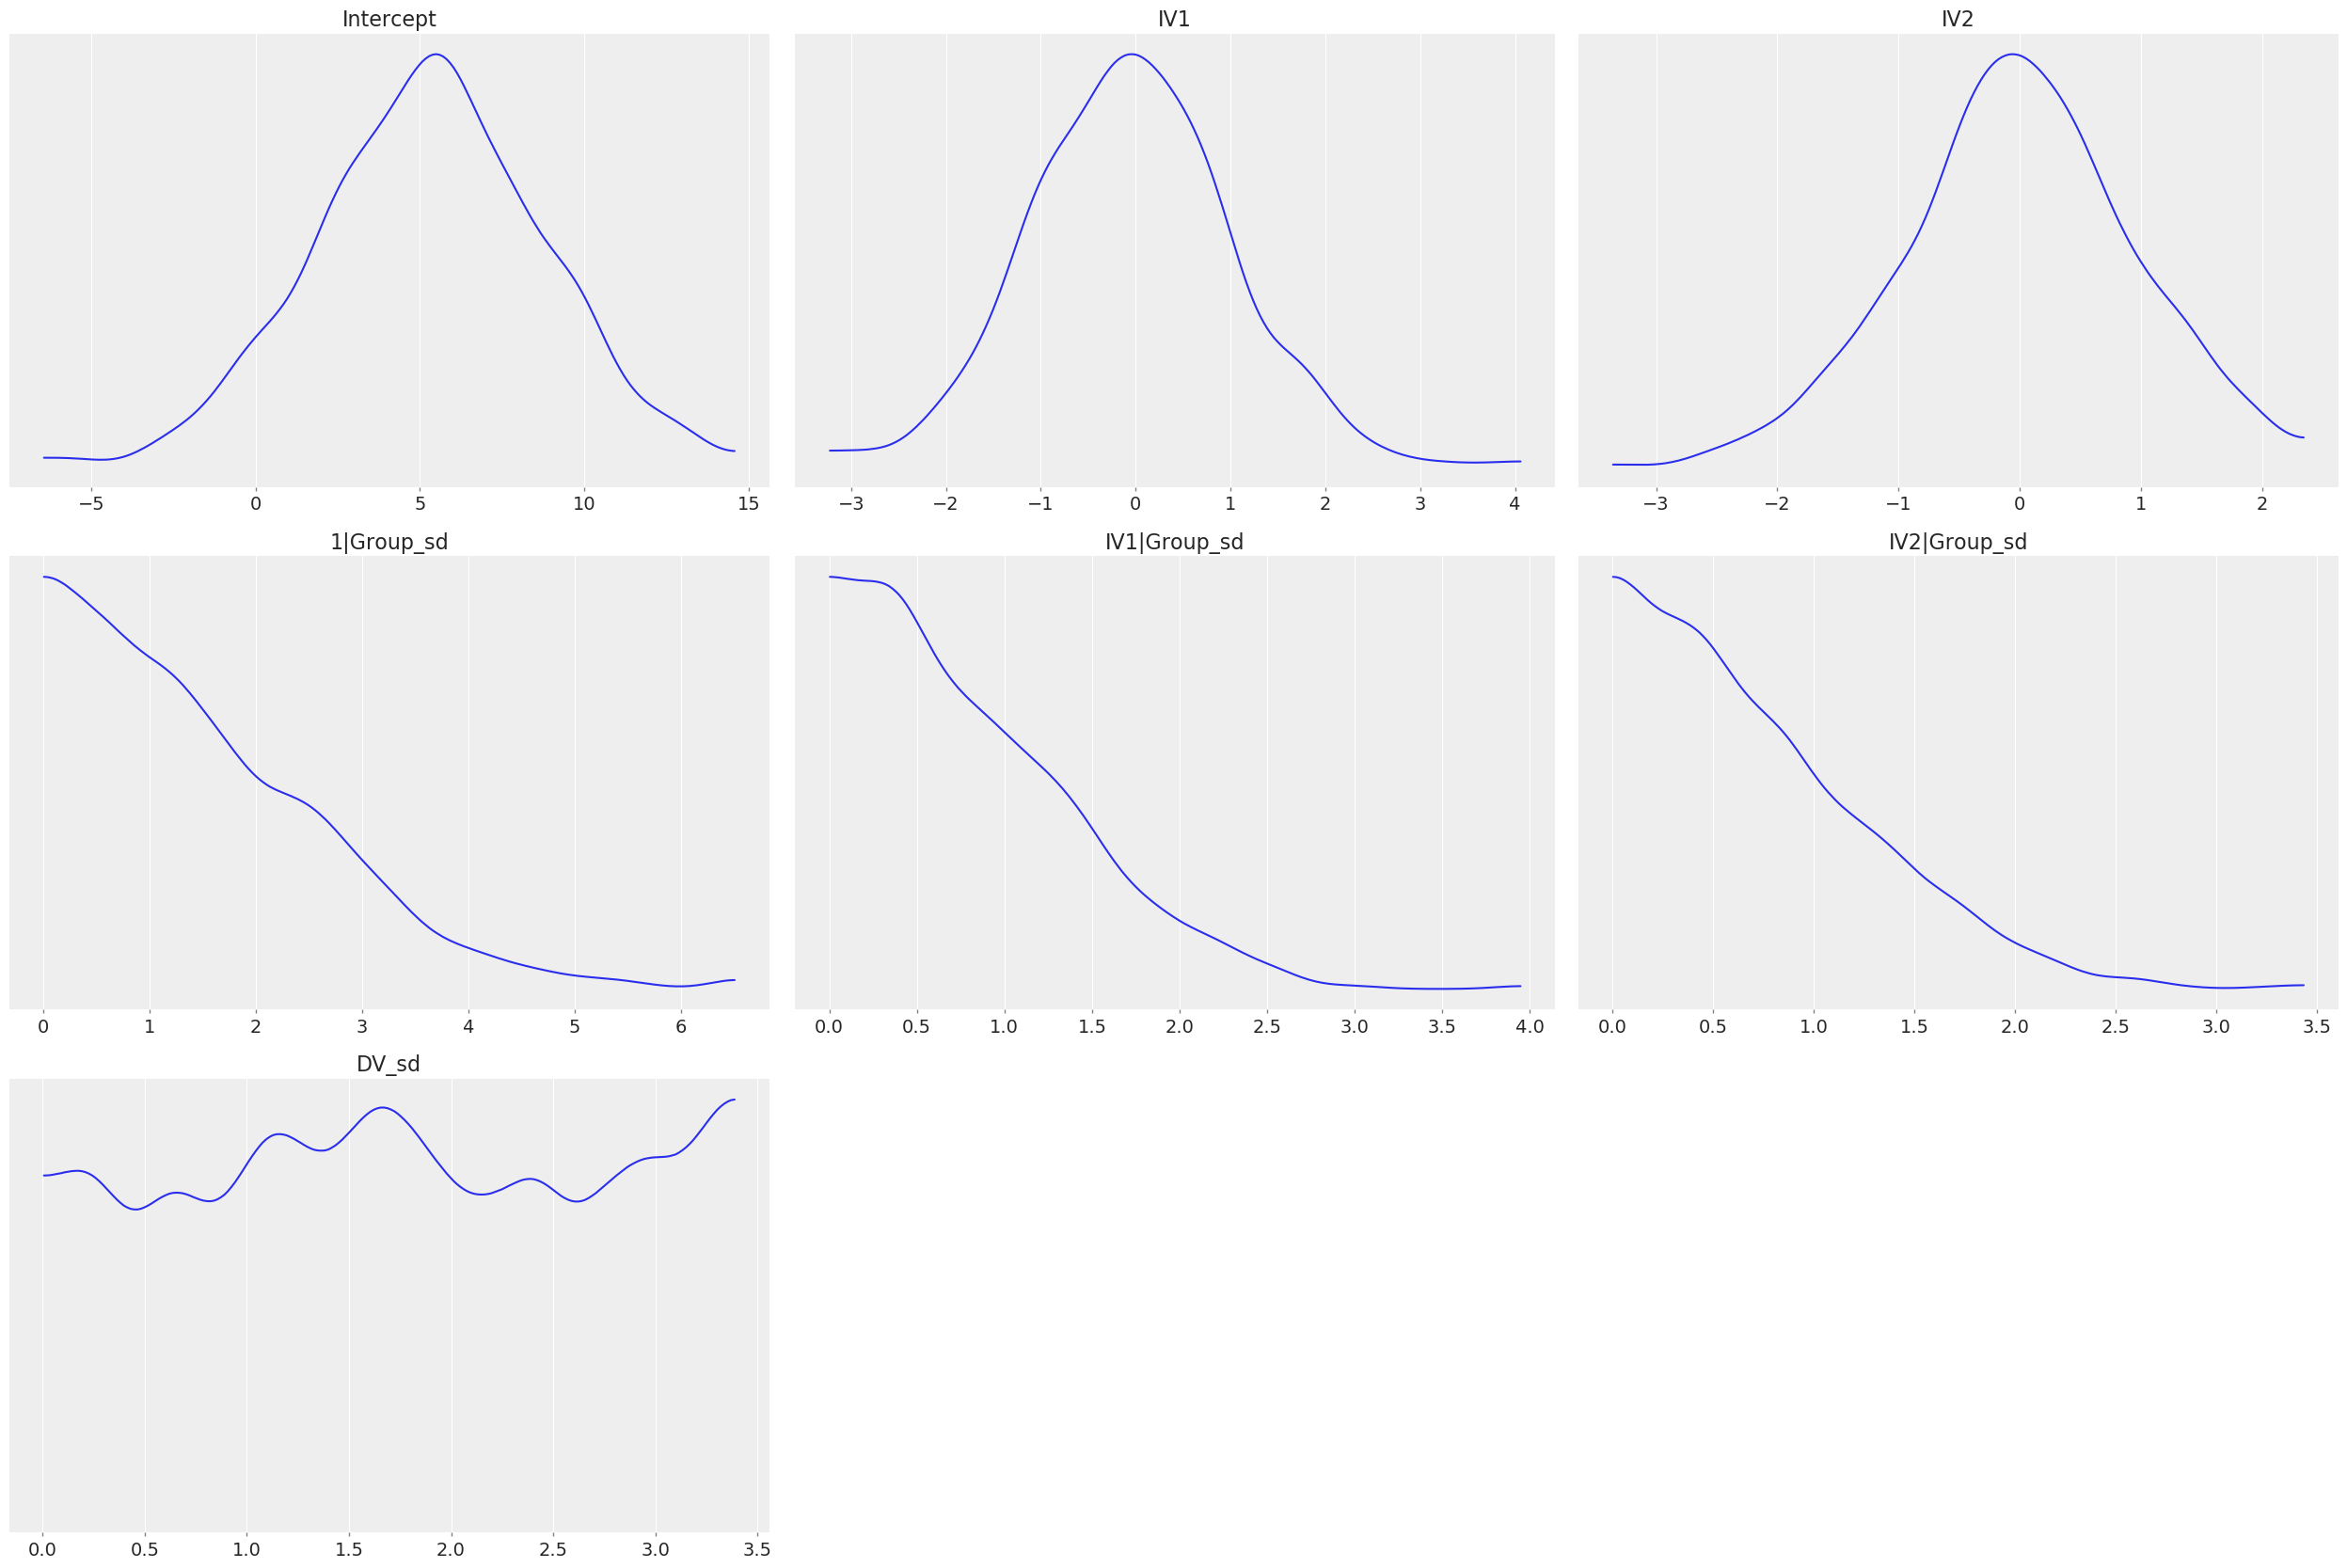

In [22]:
# Plot priors
b_model.plot();

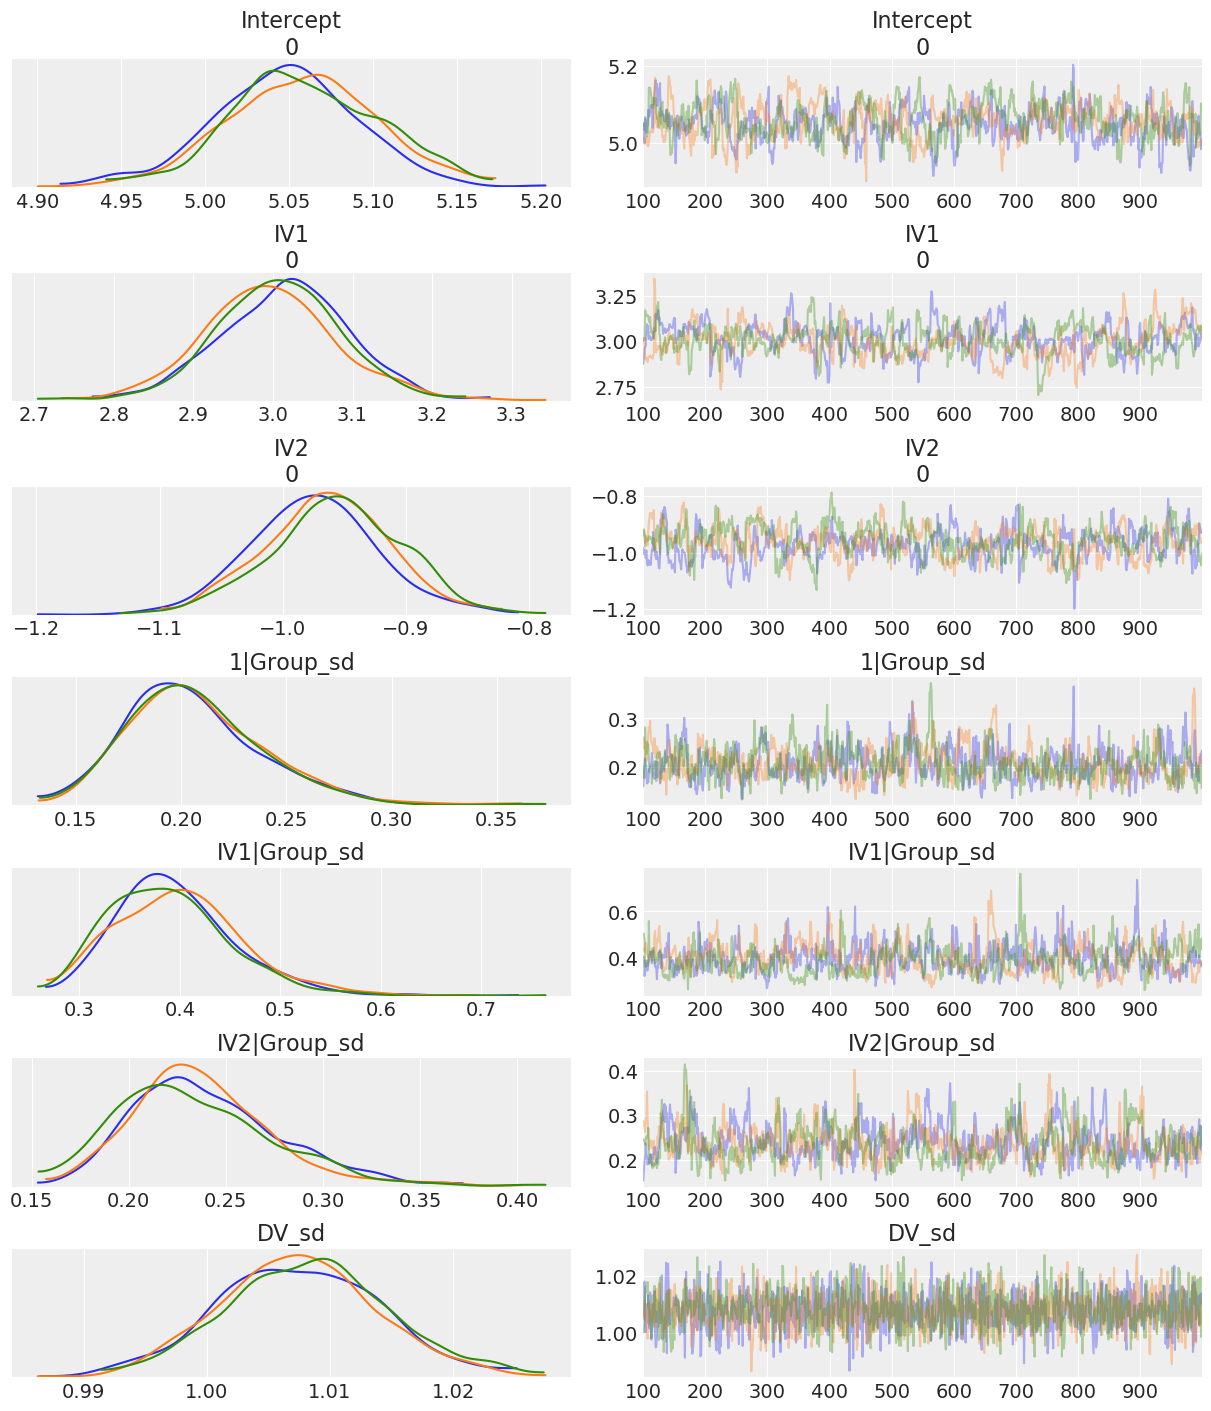

In [23]:
#Plot posteriors
results_sliced = results.posterior.sel(draw=slice(100, 1000))
az.plot_trace(results_sliced,
              var_names=['Intercept', 'IV1', 'IV2', '1|Group_sd', 'IV1|Group_sd', 'IV2|Group_sd', 'DV_sd']);

In [24]:
az.summary(results_sliced,
          var_names=['Intercept', 'IV1', 'IV2', '1|Group_sd', 'IV1|Group_sd', 'IV2|Group_sd', 'DV_sd'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],5.055,0.044,4.980,5.146,0.002,0.002,322.0,322.0,323.0,485.0,1.01
IV1[0],3.006,0.081,2.858,3.165,0.006,0.004,187.0,186.0,182.0,377.0,1.01
IV2[0],-0.965,0.052,-1.065,-0.871,0.003,0.002,234.0,233.0,234.0,540.0,1.04
1|Group_sd,0.207,0.033,0.150,0.268,0.002,0.001,371.0,368.0,391.0,593.0,1.00
IV1|Group_sd,0.395,0.061,0.289,0.503,0.003,0.002,321.0,321.0,284.0,401.0,1.03
IV2|Group_sd,0.238,0.038,0.170,0.309,0.002,0.002,306.0,306.0,310.0,700.0,1.01
DV_sd,1.008,0.006,0.995,1.020,0.000,0.000,2063.0,2063.0,2054.0,1720.0,1.00


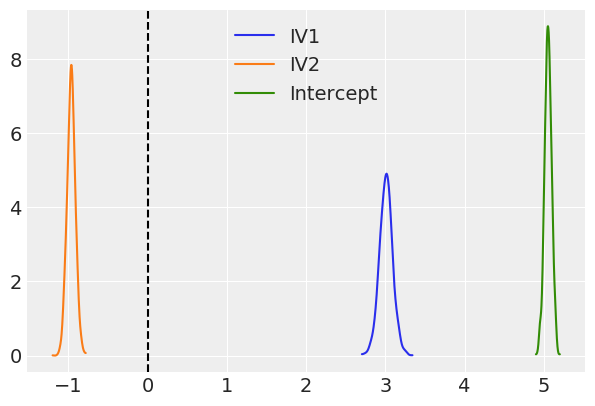

In [25]:
az.plot_kde(results.posterior['IV1'], plot_kwargs={'color':'C0'}, label='IV1');
az.plot_kde(results.posterior['IV2'], plot_kwargs={'color':'C1'}, label='IV2');
az.plot_kde(results.posterior['Intercept'], plot_kwargs={'color':'C2'}, label='Intercept');
plt.axvline(0,color='k',linestyle='--')
plt.legend();

Because we used pymc3 for the backend estimation in bambi, we have access to few extra goodies. Here we make a forest plot similar to the one above for the frequentist model, but with 95% credible intervals instead

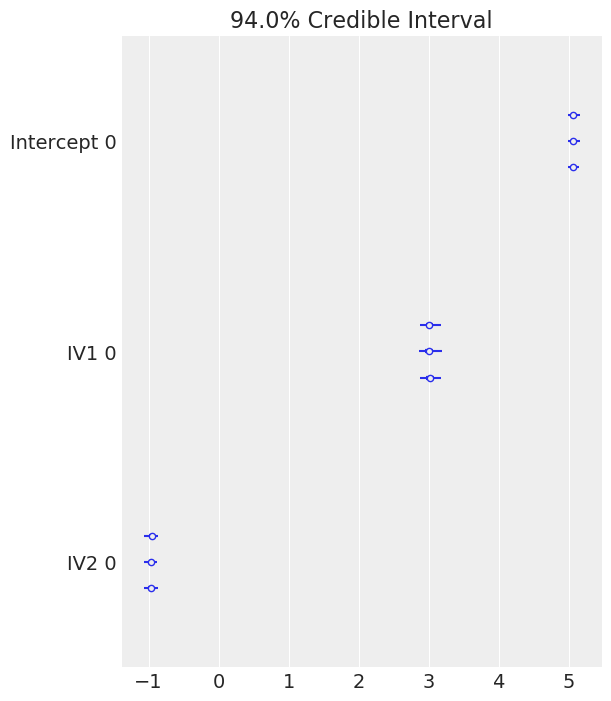

In [27]:
# Credible interval plot using pymc3
# Line is 94% credible interval calculated as higher posterior density
# Inter quartile range is thicker line
# Dot is median
az.plot_forest(results,
               var_names=list(map(str,b_model.backend.model.vars[:3])));
# this should be 
#               var_names=list(map(str,b_model.backend.model.vars[:4])));
# but we are getting the error, the reason is that by default arviz does not work with transformed variables
# as this are just numerical tricks and not relevant variables
# thus model.vars should not return transformed variables
#"['1|Group_sd_log__'] var names are not present in dataset"
# idem next cell

We can also plot the posterior overlayed with a region of practical equivalence (ROPE), i.e. range of values that were the coefficients to fall into, we might interpret them differently. 
We can see that all our posterior distributions fall outside of this range.

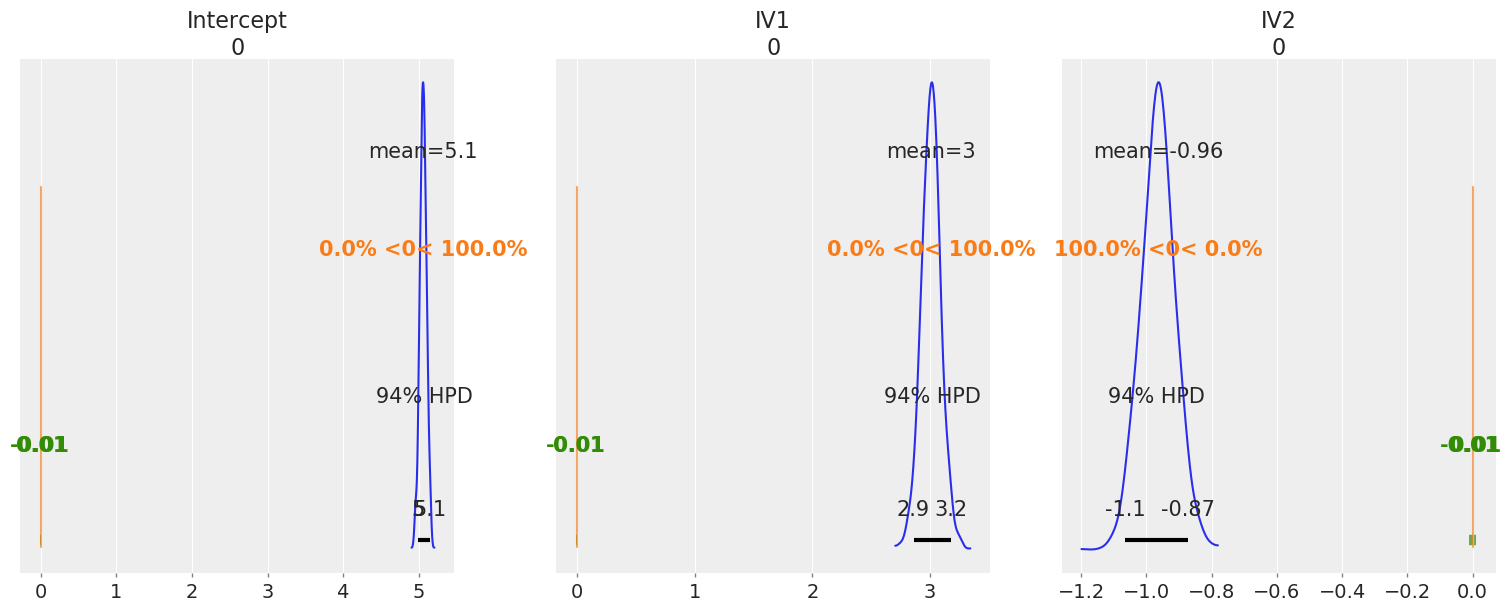

In [29]:
# Show credible interval cutoffs, and also overlay region of practical equivalence (arbitrary, in this case close enough to 0 to not matter)
pm.plot_posterior(b_model.backend.trace,
                  varnames=list(map(str, b_model.backend.model.vars[:3])),
                  ref_val=0,
                  rope=[-.01, .01],
                  figsize=(15, 6));